In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy
import networkx as nx
import stream2 as st2

/usr/conda/envs/x/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.chdir('GitHub/STREAM2_tutorials/tutorial_notebooks/')

# Data
We load example data taken from monocle3 tutorials (https://cole-trapnell-lab.github.io/monocle3/docs/clustering/). 

The adata.X slot is empty as we will simply make use of the PCA and low dimensional representation to illustrate STREAM2 features for complex trajectories

/usr/conda/envs/x/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


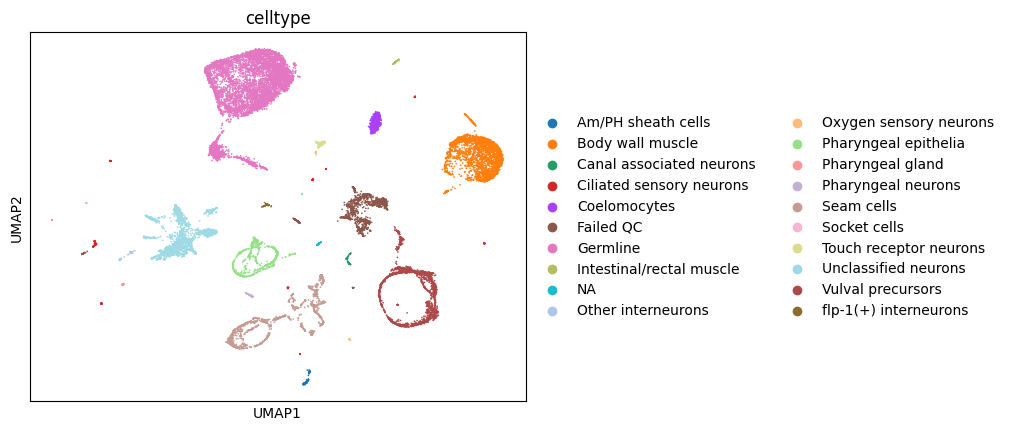

In [4]:
adata = sc.read('../data/monocle/clus_tutorial_monocle.h5ad')
sc.pp.subsample(adata,fraction=.5)
sc.pl.umap(adata,color=['celltype'])

We will first identify disconnected components in the data.

This requires kNN search and a vector of cluster labels. Here we will take leiden clustering labels as input

Found 38 components


/usr/conda/envs/x/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


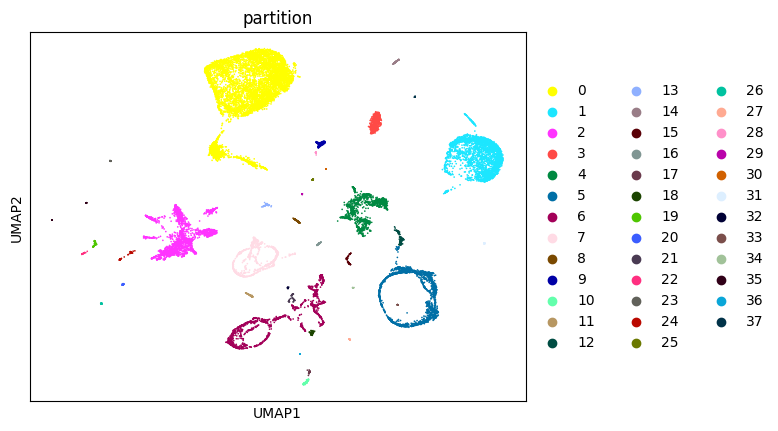

In [5]:
sc.pp.neighbors(adata,use_rep='X_umap')
sc.tl.leiden(adata)
st2.tl.find_disconnected_components(adata,groups='leiden')
sc.pl.umap(adata,color='partition')

With default parameters, we find 34 distinct components in the data. 

Many are small clusters which are not adequate for trajectory inference and can be filtered out

<Axes: >

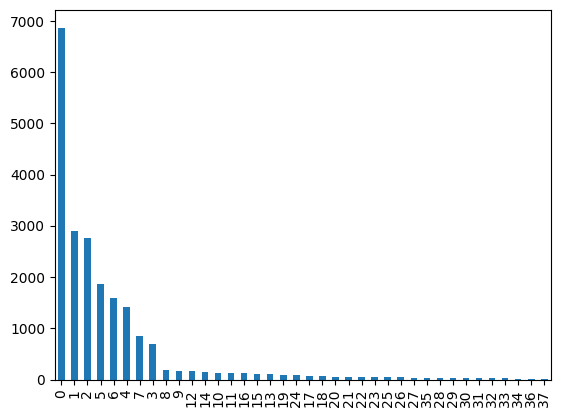

In [6]:
adata.obs['partition'].value_counts().plot.bar()

We keep components with more than 500 cells

In [7]:
big_components_idx = np.where(np.bincount(adata.obs['partition'])>500)[0]
adata = adata[np.isin(adata.obs['partition'],big_components_idx.astype(str))]

Now let's find a first guess of the graph

Seeding initial graph for each partition...


/usr/conda/envs/x/lib/python3.9/site-packages/stream2/tools/_elpigraph.py:515: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["seed_epg"] = {}


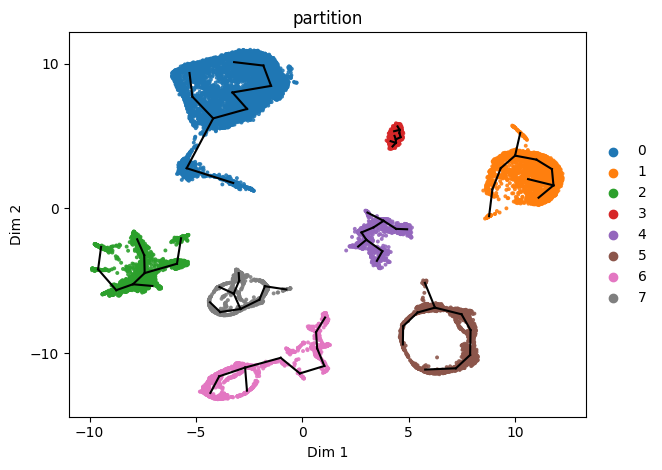

In [8]:
st2.tl.seed_graph(adata,use_partition=True)
st2.pl.graph(adata,key='seed_epg',color=['partition'])

Now we refine the initial guess by learning the principal graph. 

Partitions initialized with higher n_clusters than n_nodes will automatically adjust n_nodes higher to n_nodes = n_clusters+1 

Learning elastic principal graph for each partition...


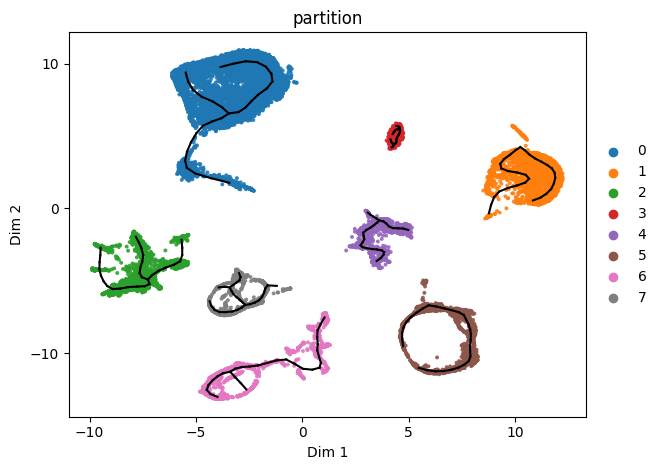

In [9]:
st2.tl.learn_graph(adata,n_nodes=30,use_partition=True)
st2.pl.graph(adata,key='epg',color=['partition'])

In practice we will likely need to further adjust graph learning parameters for different partitions

Here e.g., we decide to tune graph parameters for red, grey, pink and brown partitions

We simply need to change the use_partition parameter to a list

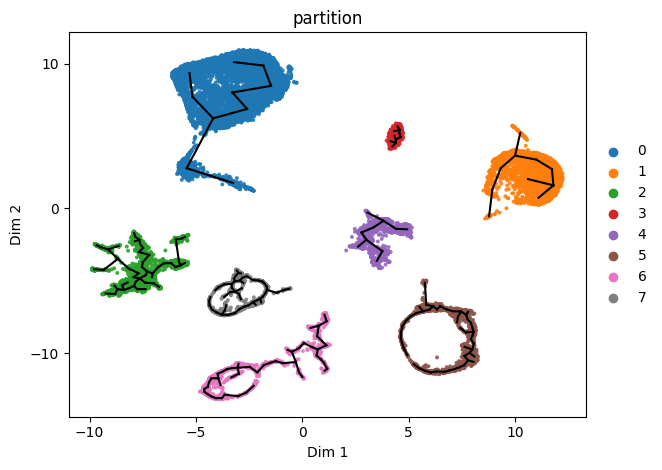

In [14]:
st2.pl.graph(adata,key='seed_epg',color=['partition'])

In [10]:
use_partition=['2','5','6','7']
st2.tl.seed_graph(adata,n_clusters=50,use_partition=use_partition)
st2.tl.learn_graph(adata,n_nodes=60,epg_alpha=0.01,epg_mu=0.05,use_partition=use_partition)
st2.pl.graph(adata,key='seed_epg',color=['partition'])
st2.pl.graph(adata,key='epg',color=['partition'])

Seeding initial graph for each partition...
Learning elastic principal graph for each partition...


ValueError: use_partition should be a bool

Finally we can use heuristics to choose plausible loops / missing paths to add to the graph

Searching potential loops for each partition...
Using default parameters: max_n_points=343, radius=1.50, min_node_n_points=7,min_path_len=6, nnodes=6
testing 0 candidates
No valid loops found
Using default parameters: max_n_points=137, radius=1.50, min_node_n_points=1,min_path_len=12, nnodes=6
testing 0 candidates
No valid loops found
Using default parameters: max_n_points=145, radius=1.50, min_node_n_points=1,min_path_len=6, nnodes=6
testing 10 candidates
No valid loops found
Using default parameters: max_n_points=34, radius=1.50, min_node_n_points=10,min_path_len=6, nnodes=16
testing 104 candidates
No valid loops found
Using default parameters: max_n_points=42, radius=1.50, min_node_n_points=1,min_path_len=12, nnodes=8
testing 72 candidates
Using default parameters: max_n_points=70, radius=1.50, min_node_n_points=3,min_path_len=6, nnodes=6
testing 20 candidates
No valid loops found
Using default parameters: max_n_points=94, radius=1.50, min_node_n_points=1,min_path_len=12, nnodes=6
t

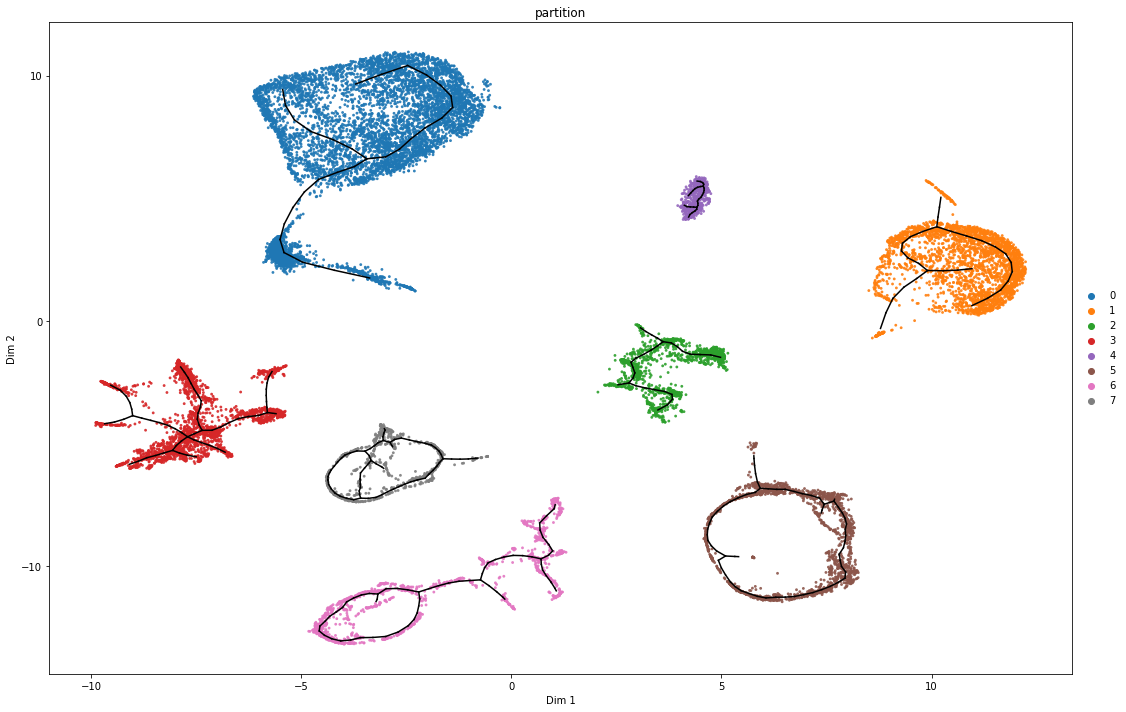

In [ ]:
adata2=adata.copy()
st2.tl.add_loops(adata2,min_node_n_points=None,
                        max_n_points=None,
                        max_inner_fraction=.2,
                        radius=1.5,
                        use_partition=True,verbose=1)
st2.pl.graph(adata2,key='epg',color=['partition'],fig_size=(15,10))

We decide to further analyze the pink partition separately and notice it is missing some paths we want to explore.

We can fix this using add_path

In [ ]:
sadata = st2.tl.get_component(adata,'6')
st2.tl._elpigraph._store_graph_attributes(sadata,sadata.obsm['X_umap'],'epg')
st2.pl.graph(sadata,key='epg',color=['partition'])

st2.tl.add_path(sadata,source=3,target=37)
st2.pl.graph(sadata,key='epg',color=['partition'],show_text=True)

st2.tl.add_path(sadata,source=68,target=28)
st2.pl.graph(sadata,key='epg',color=['partition'],show_text=True)

st2.tl.add_path(sadata,source=72,target=16)
st2.pl.graph(sadata,key='epg',color=['partition'])

TypeError: _subset_adata() takes 2 positional arguments but 3 were given